In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMaker import *

In [2]:
IMAGE_SHAPE = (5, 127, 127)
GB_LIMIT = 5

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 1000
LEARNING_RATE = 0.0005
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training_{Z_MAX}_small.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation_{Z_MAX}_small.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing_{Z_MAX}_small.hdf5'

In [6]:
column_names = ['object_id', 'specz_redshift', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
with h5py.File(TRAIN_PATH, 'r') as hf:
    train_df = pd.DataFrame()
    for name in column_names:
        train_df[name] = hf[name][:]
    
with h5py.File(VAL_PATH, 'r') as hf:
    val_df = pd.DataFrame()
    for name in column_names:
        val_df[name] = hf[name][:]
    
with h5py.File(TEST_PATH, 'r') as hf:
    test_df = pd.DataFrame()
    for name in column_names:
        test_df[name] = hf[name][:]

In [7]:
mags = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
X_train, X_val, X_test = train_df[mags], val_df[mags], test_df[mags]
y_train, y_val, y_test = train_df['specz_redshift'], val_df['specz_redshift'], test_df['specz_redshift']
OID_train, OID_val, OID_test = train_df['object_id'], val_df['object_id'], test_df['object_id']

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [9]:
# for now, only run the NN architecture
# add callbacks

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_nn = Input(shape=X_train.shape[1:])
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)

concat = Concatenate()([input_nn, hidden4])
distribution_params = Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = Model(inputs=[input_nn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          1200        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          40200       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 200)          40200       dense_1[0][0]                    
______________________________________________________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_small_v3'

checkpoint_filepath = os.path.join('/models/', model_name)+'/'+model_name
log_dir = os.path.join('/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(x=[X_train], y=y_train, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=([X_val], y_val), callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/1000
40/40 [==============================] - 1s 11ms/step - loss: 0.5860 - mse: 0.5385 - val_loss: 0.3644 - val_mse: 0.2237
Epoch 2/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.2522 - mse: 0.1463 - val_loss: 0.1882 - val_mse: 0.1651
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1751 - mse: 0.1540 - val_loss: 0.1918 - val_mse: 0.1624
Epoch 4/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1740 - mse: 0.1520 - val_loss: 0.1826 - val_mse: 0.1594
Epoch 5/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1711 - mse: 0.1479 - val_loss: 0.1715 - val_mse: 0.1556
Epoch 6/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1612 - mse: 0.1408 - val_loss: 0.1686 - val_mse: 0.1632
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1615 - mse: 0.1500 - val_loss: 0.1732 - val_mse: 0.1589
Epoch 8/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.1120 - mse: 0.0948 - val_loss: 0.1198 - val_mse: 0.0937
Epoch 63/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1124 - mse: 0.0952 - val_loss: 0.1189 - val_mse: 0.0875
Epoch 64/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1104 - mse: 0.0946 - val_loss: 0.1204 - val_mse: 0.0879
Epoch 65/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1132 - mse: 0.0938 - val_loss: 0.1192 - val_mse: 0.0894
Epoch 66/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1085 - mse: 0.0918 - val_loss: 0.1194 - val_mse: 0.0909
Epoch 67/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.1099 - mse: 0.0951 - val_loss: 0.1236 - val_mse: 0.0894
Epoch 68/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1130 - mse: 0.0957 - val_loss: 0.1239 - val_mse: 0.0879
Epoch 69/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1133 -

40/40 [==============================] - 0s 2ms/step - loss: 0.0938 - mse: 0.0883 - val_loss: 0.1056 - val_mse: 0.0831
Epoch 124/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0939 - mse: 0.0881 - val_loss: 0.1037 - val_mse: 0.0794
Epoch 125/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0894 - val_loss: 0.1058 - val_mse: 0.0817
Epoch 126/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0964 - mse: 0.0887 - val_loss: 0.1054 - val_mse: 0.0843
Epoch 127/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0959 - mse: 0.0899 - val_loss: 0.1169 - val_mse: 0.0792
Epoch 128/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0949 - mse: 0.0883 - val_loss: 0.1021 - val_mse: 0.0802
Epoch 129/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0957 - mse: 0.0881 - val_loss: 0.1064 - val_mse: 0.0805
Epoch 130/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0871 - mse: 0.0864 - val_loss: 0.1019 - val_mse: 0.0818
Epoch 185/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0877 - mse: 0.0875 - val_loss: 0.1022 - val_mse: 0.0813
Epoch 186/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0864 - mse: 0.0865 - val_loss: 0.1021 - val_mse: 0.0825
Epoch 187/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0888 - mse: 0.0871 - val_loss: 0.1027 - val_mse: 0.0816
Epoch 188/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0869 - mse: 0.0865 - val_loss: 0.1049 - val_mse: 0.0853
Epoch 189/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0933 - mse: 0.0912 - val_loss: 0.1028 - val_mse: 0.0829
Epoch 190/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0863 - mse: 0.0877 - val_loss: 0.1004 - val_mse: 0.0814
Epoch 191/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 3ms/step - loss: 0.0833 - mse: 0.0865 - val_loss: 0.1024 - val_mse: 0.0812
Epoch 246/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0893 - mse: 0.0855 - val_loss: 0.1051 - val_mse: 0.0836
Epoch 247/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0866 - mse: 0.0859 - val_loss: 0.1034 - val_mse: 0.0824
Epoch 248/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0832 - mse: 0.0859 - val_loss: 0.0979 - val_mse: 0.0815
Epoch 249/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0815 - mse: 0.0846 - val_loss: 0.1042 - val_mse: 0.0827
Epoch 250/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0821 - mse: 0.0848 - val_loss: 0.1017 - val_mse: 0.0834
Epoch 251/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0810 - mse: 0.0863 - val_loss: 0.1002 - val_mse: 0.0798
Epoch 252/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0764 - mse: 0.0811 - val_loss: 0.0992 - val_mse: 0.0815
Epoch 307/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0750 - mse: 0.0812 - val_loss: 0.1009 - val_mse: 0.0832
Epoch 308/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0757 - mse: 0.0801 - val_loss: 0.0972 - val_mse: 0.0803
Epoch 309/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0745 - mse: 0.0806 - val_loss: 0.1001 - val_mse: 0.0866
Epoch 310/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0756 - mse: 0.0813 - val_loss: 0.1004 - val_mse: 0.0822
Epoch 311/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0748 - mse: 0.0817 - val_loss: 0.1024 - val_mse: 0.0842
Epoch 312/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0754 - mse: 0.0805 - val_loss: 0.1035 - val_mse: 0.0832
Epoch 313/1000
40/40 [==============================] - 0s 3ms/step - loss: 0

40/40 [==============================] - 0s 3ms/step - loss: 0.0722 - mse: 0.0787 - val_loss: 0.1021 - val_mse: 0.0845
Epoch 368/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0774 - mse: 0.0805 - val_loss: 0.0989 - val_mse: 0.0814
Epoch 369/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0709 - mse: 0.0805 - val_loss: 0.1017 - val_mse: 0.0824
Epoch 370/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0741 - mse: 0.0776 - val_loss: 0.1027 - val_mse: 0.0842
Epoch 371/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0710 - mse: 0.0790 - val_loss: 0.0987 - val_mse: 0.0836
Epoch 372/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0722 - mse: 0.0813 - val_loss: 0.0978 - val_mse: 0.0829
Epoch 373/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0699 - mse: 0.0798 - val_loss: 0.1014 - val_mse: 0.0840
Epoch 374/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0689 - mse: 0.0774 - val_loss: 0.1012 - val_mse: 0.0855
Epoch 429/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0691 - mse: 0.0768 - val_loss: 0.1039 - val_mse: 0.0869
Epoch 430/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0680 - mse: 0.0770 - val_loss: 0.1008 - val_mse: 0.0859
Epoch 431/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0669 - mse: 0.0781 - val_loss: 0.0997 - val_mse: 0.0839
Epoch 432/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0666 - mse: 0.0775 - val_loss: 0.1022 - val_mse: 0.0895
Epoch 433/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0660 - mse: 0.0763 - val_loss: 0.0985 - val_mse: 0.0849
Epoch 434/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0655 - mse: 0.0756 - val_loss: 0.1009 - val_mse: 0.0845
Epoch 435/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0628 - mse: 0.0754 - val_loss: 0.0976 - val_mse: 0.0832
Epoch 490/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0637 - mse: 0.0743 - val_loss: 0.0999 - val_mse: 0.0878
Epoch 491/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0638 - mse: 0.0749 - val_loss: 0.0976 - val_mse: 0.0830
Epoch 492/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0657 - mse: 0.0758 - val_loss: 0.1004 - val_mse: 0.0803
Epoch 493/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0672 - mse: 0.0751 - val_loss: 0.1027 - val_mse: 0.0864
Epoch 494/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0636 - mse: 0.0751 - val_loss: 0.1008 - val_mse: 0.0889
Epoch 495/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0662 - mse: 0.0757 - val_loss: 0.1010 - val_mse: 0.0842
Epoch 496/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0593 - mse: 0.0720 - val_loss: 0.1039 - val_mse: 0.0828
Epoch 551/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0597 - mse: 0.0718 - val_loss: 0.1020 - val_mse: 0.0878
Epoch 552/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0611 - mse: 0.0723 - val_loss: 0.1004 - val_mse: 0.0828
Epoch 553/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0597 - mse: 0.0708 - val_loss: 0.1007 - val_mse: 0.0832
Epoch 554/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0659 - mse: 0.0752 - val_loss: 0.0978 - val_mse: 0.0828
Epoch 555/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0592 - mse: 0.0721 - val_loss: 0.1035 - val_mse: 0.0838
Epoch 556/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0633 - mse: 0.0710 - val_loss: 0.1030 - val_mse: 0.0901
Epoch 557/1000
40/40 [==============================] - 0s 3ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0616 - mse: 0.0684 - val_loss: 0.1033 - val_mse: 0.0840
Epoch 612/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0570 - mse: 0.0675 - val_loss: 0.1035 - val_mse: 0.0850
Epoch 613/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0563 - mse: 0.0671 - val_loss: 0.1014 - val_mse: 0.0829
Epoch 614/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0550 - mse: 0.0674 - val_loss: 0.1005 - val_mse: 0.0824
Epoch 615/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0542 - mse: 0.0672 - val_loss: 0.1019 - val_mse: 0.0858
Epoch 616/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0560 - mse: 0.0668 - val_loss: 0.1002 - val_mse: 0.0802
Epoch 617/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0564 - mse: 0.0682 - val_loss: 0.1035 - val_mse: 0.0807
Epoch 618/1000
40/40 [==============================] - 0s 3ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0516 - mse: 0.0630 - val_loss: 0.1010 - val_mse: 0.0787
Epoch 673/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0573 - mse: 0.0659 - val_loss: 0.1025 - val_mse: 0.0843
Epoch 674/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0590 - mse: 0.0655 - val_loss: 0.1056 - val_mse: 0.0842
Epoch 675/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0575 - mse: 0.0636 - val_loss: 0.1036 - val_mse: 0.0822
Epoch 676/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0518 - mse: 0.0635 - val_loss: 0.1030 - val_mse: 0.0831
Epoch 677/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0519 - mse: 0.0646 - val_loss: 0.1014 - val_mse: 0.0792
Epoch 678/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0526 - mse: 0.0648 - val_loss: 0.1026 - val_mse: 0.0806
Epoch 679/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0493 - mse: 0.0606 - val_loss: 0.1028 - val_mse: 0.0814
Epoch 734/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0508 - mse: 0.0616 - val_loss: 0.1041 - val_mse: 0.0812
Epoch 735/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0521 - mse: 0.0614 - val_loss: 0.1094 - val_mse: 0.0873
Epoch 736/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0506 - mse: 0.0617 - val_loss: 0.1028 - val_mse: 0.0800
Epoch 737/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0507 - mse: 0.0616 - val_loss: 0.1057 - val_mse: 0.0827
Epoch 738/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0490 - mse: 0.0609 - val_loss: 0.1047 - val_mse: 0.0811
Epoch 739/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0478 - mse: 0.0606 - val_loss: 0.1027 - val_mse: 0.0824
Epoch 740/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0472 - mse: 0.0589 - val_loss: 0.1017 - val_mse: 0.0795
Epoch 795/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0457 - mse: 0.0588 - val_loss: 0.1044 - val_mse: 0.0810
Epoch 796/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0450 - mse: 0.0585 - val_loss: 0.1140 - val_mse: 0.0845
Epoch 797/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0477 - mse: 0.0588 - val_loss: 0.1039 - val_mse: 0.0833
Epoch 798/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0466 - mse: 0.0581 - val_loss: 0.1029 - val_mse: 0.0811
Epoch 799/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0458 - mse: 0.0583 - val_loss: 0.1029 - val_mse: 0.0802
Epoch 800/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0491 - mse: 0.0596 - val_loss: 0.1067 - val_mse: 0.0812
Epoch 801/1000
40/40 [==============================] - 0s 3ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0440 - mse: 0.0575 - val_loss: 0.1053 - val_mse: 0.0832
Epoch 856/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0441 - mse: 0.0570 - val_loss: 0.1080 - val_mse: 0.0852
Epoch 857/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0427 - mse: 0.0571 - val_loss: 0.1069 - val_mse: 0.0848
Epoch 858/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0423 - mse: 0.0577 - val_loss: 0.1079 - val_mse: 0.0855
Epoch 859/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0412 - mse: 0.0575 - val_loss: 0.1062 - val_mse: 0.0829
Epoch 860/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0416 - mse: 0.0565 - val_loss: 0.1064 - val_mse: 0.0833
Epoch 861/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0434 - mse: 0.0568 - val_loss: 0.1084 - val_mse: 0.0857
Epoch 862/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0474 - mse: 0.0582 - val_loss: 0.1085 - val_mse: 0.0849
Epoch 917/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0499 - mse: 0.0587 - val_loss: 0.1092 - val_mse: 0.0888
Epoch 918/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0450 - mse: 0.0569 - val_loss: 0.1076 - val_mse: 0.0835
Epoch 919/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0423 - mse: 0.0564 - val_loss: 0.1076 - val_mse: 0.0841
Epoch 920/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0440 - mse: 0.0573 - val_loss: 0.1062 - val_mse: 0.0867
Epoch 921/1000
40/40 [==============================] - 0s 3ms/step - loss: 0.0439 - mse: 0.0562 - val_loss: 0.1088 - val_mse: 0.0843
Epoch 922/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0418 - mse: 0.0562 - val_loss: 0.1059 - val_mse: 0.0849
Epoch 923/1000
40/40 [==============================] - 0s 2ms/step - loss: 0

40/40 [==============================] - 0s 2ms/step - loss: 0.0380 - mse: 0.0535 - val_loss: 0.1104 - val_mse: 0.0836
Epoch 978/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0529 - val_loss: 0.1066 - val_mse: 0.0834
Epoch 979/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0412 - mse: 0.0542 - val_loss: 0.1090 - val_mse: 0.0836
Epoch 980/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0400 - mse: 0.0534 - val_loss: 0.1088 - val_mse: 0.0854
Epoch 981/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0416 - mse: 0.0539 - val_loss: 0.1088 - val_mse: 0.0814
Epoch 982/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0649 - mse: 0.0693 - val_loss: 0.1136 - val_mse: 0.0804
Epoch 983/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0543 - mse: 0.0621 - val_loss: 0.1076 - val_mse: 0.0809
Epoch 984/1000
40/40 [==============================] - 0s 3ms/step - loss: 0

In [16]:
evaluated_model = model(X_test)

In [17]:
mean_arr = evaluated_model.mean().numpy()
std_arr = evaluated_model.stddev().numpy()

In [18]:
y_pred = np.ravel(mean_arr) # to make ndim = 1
y_pred

array([0.2762336 , 0.25454158, 0.56498164, ..., 0.05041073, 0.6765756 ,
       0.7263919 ], dtype=float32)

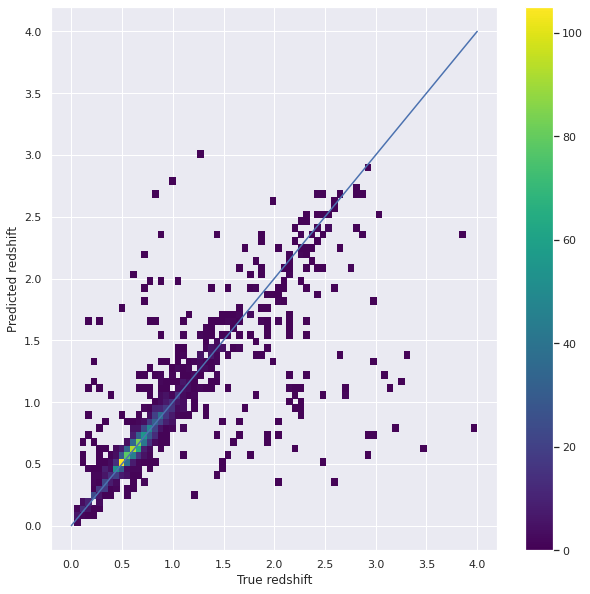

In [19]:
plot_predictions(y_pred, y_test)

In [20]:
metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test))

In [21]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.10767,0.003965,0.003807,0.036687,0.031031,0.151,0.0735,0.091202


In [22]:
df = pd.DataFrame(y_pred, columns=['photoz'])
df['photz_err'] = np.ravel(std_arr)
df['specz'] = y_test
df['object_id'] = OID_test
if os.path.exists(f'/predictions/{model_name}') == False:
    os.makedirs(f'/predictions/{model_name}')
    
df.to_csv(f'/predictions/{model_name}/testing_predictions.csv', index=False)

In [23]:
if os.path.exists(f'predictions/{model_name}') ==  False:
    os.makedirs(f'predictions/{model_name}')
    
metrics.to_csv(f'/predictions/{model_name}/testing_metrics.csv', index=False)

In [24]:
y_train

0       2.17865
1       0.84550
2       0.44850
3       0.37001
4       0.58149
         ...   
9995    0.76330
9996    0.81340
9997    0.64226
9998    0.49758
9999    0.57557
Name: specz_redshift, Length: 10000, dtype: float64

In [25]:
# v1 batch_size = 256
# v2 batch_size = None